<a href="https://colab.research.google.com/github/rajeshbuny/Multi_Image_classification/blob/master/Busigence_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 1 Image Classification**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
import random

# **External module to load data and splitting**

In [0]:
import os
import glob
import numpy as np
import cv2
from sklearn.utils import shuffle


def load_train(train_path, image_size, classes):
    images = []
    labels = []
    ids = []
    cls = []

    print('Reading training images')
    for fld in classes:   # assuming data directory has a separate folder for each class, and that each folder is named after the class
        index = classes.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            image = cv2.imread(fl)
            image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
            images.append(image)
            label = np.zeros(len(classes))
            label[index] = 1.0
            labels.append(label)
            flbase = os.path.basename(fl)
            ids.append(flbase)
            cls.append(fld)
    images = np.array(images)
    labels = np.array(labels)
    ids = np.array(ids)
    cls = np.array(cls)

    return images, labels, ids, cls


def load_test(test_path, image_size):
  path = os.path.join(test_path, '*g')
  files = sorted(glob.glob(path))

  X_test = []
  X_test_id = []
  print("Reading test images")
  for fl in files:
      flbase = os.path.basename(fl)
      img = cv2.imread(fl)
      img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
      X_test.append(img)
      X_test_id.append(flbase)

  ### because we're not creating a DataSet object for the test images, normalization happens here
  X_test = np.array(X_test, dtype=np.uint8)
  X_test = X_test.astype('float32')
  X_test = X_test / 255

  return X_test, X_test_id



class DataSet(object):

  def __init__(self, images, labels, ids, cls):
    """Construct a DataSet. one_hot arg is used only if fake_data is true."""

    self._num_examples = images.shape[0]


    # Convert shape from [num examples, rows, columns, depth]
    # to [num examples, rows*columns] (assuming depth == 1)
    # Convert from [0, 255] -> [0.0, 1.0].

    images = images.astype(np.float32)
    images = np.multiply(images, 1.0 / 255.0)

    self._images = images
    self._labels = labels
    self._ids = ids
    self._cls = cls
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def ids(self):
    return self._ids

  @property
  def cls(self):
    return self._cls

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size):
    """Return the next `batch_size` examples from this data set."""
    start = self._index_in_epoch
    self._index_in_epoch += batch_size

    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1

      # # Shuffle the data (maybe)
      # perm = np.arange(self._num_examples)
      # np.random.shuffle(perm)
      # self._images = self._images[perm]
      # self._labels = self._labels[perm]
      # Start next epoch

      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch

    return self._images[start:end], self._labels[start:end], self._ids[start:end], self._cls[start:end]


def read_train_sets(train_path, image_size, classes, validation_size=0):
  class DataSets(object):
    pass
  data_sets = DataSets()

  images, labels, ids, cls = load_train(train_path, image_size, classes)
  images, labels, ids, cls = shuffle(images, labels, ids, cls)  # shuffle the data

  if isinstance(validation_size, float):
    validation_size = int(validation_size * images.shape[0])

  validation_images = images[:validation_size]
  validation_labels = labels[:validation_size]
  validation_ids = ids[:validation_size]
  validation_cls = cls[:validation_size]

  train_images = images[validation_size:]
  train_labels = labels[validation_size:]
  train_ids = ids[validation_size:]
  train_cls = cls[validation_size:]

  data_sets.train = DataSet(train_images, train_labels, train_ids, train_cls)
  data_sets.valid = DataSet(validation_images, validation_labels, validation_ids, validation_cls)

  return data_sets


def read_test_set(test_path, image_size):
  images, ids  = load_test(test_path, image_size)
  return images, ids

# **Configurations and Hyperparameters Setting**

In [0]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ['category 1', 'category 2', 'category 3' , 'category 4']
num_classes = len(classes)

# batch size
batch_size = 32

# validation split
validation_size = .2

# how long to wait after validation loss stops improving before terminating training
early_stopping = None

# paths
train_path = 'drive/My Drive/Input/Dataset/train/'
test_path = 'drive/My Drive/Input/Dataset/test/'
checkpoint_dir = "drive/My Drive/models/"


# **Loading The Dataset**

In [0]:
data = read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = read_test_set(test_path, img_size)

Reading training images
Loading category 1 files (Index: 0)
Loading category 2 files (Index: 1)
Loading category 3 files (Index: 2)
Loading category 4 files (Index: 3)
Reading test images


In [0]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		352
- Test-set:		30
- Validation-set:	88


In [0]:

def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Ploting the dataset randomly with labels

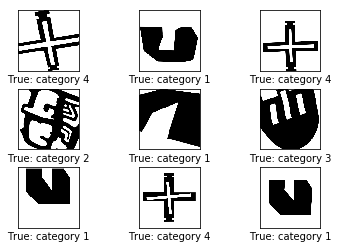

In [0]:
images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# **TensorFlow Run**
## Create TensorFlow session

In [0]:

#
tf.summary.FileWriterCache.clear()
session = tf.Session()


x = tf.placeholder(tf.float32, shape=[None, img_size,img_size,num_channels], name='x')

## labels
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

W0802 07:32:21.012135 139825927694208 deprecation.py:506] From <ipython-input-9-0d7bc15f178b>:9: calling argmax (from tensorflow.python.ops.math_ops) with dimension is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


In [0]:

def create_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def create_biases(size):
    return tf.Variable(tf.constant(0.05, shape=[size]))


# Creating Convolutional Layers
## Using Convolutional Neural Network (CNN) algorithm
Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [0]:
def create_convolutional_layer(input,
               num_input_channels, 
               conv_filter_size,        
               num_filters):  
    
    ## We shall define the weights that will be trained using create_weights function.
    weights = create_weights(shape=[conv_filter_size, conv_filter_size, num_input_channels, num_filters])
    ## We create biases using the create_biases function. These are also trained.
    biases = create_biases(num_filters)

    ## Creating the convolutional layer
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')

    layer += biases

    ## We shall be using max-pooling.  
    layer = tf.nn.max_pool(value=layer,
                            ksize=[1, 2, 2, 1],
                            strides=[1, 2, 2, 1],
                            padding='SAME')
    ## Output of pooling is fed to Relu which is the activation function for us.
    layer = tf.nn.relu(layer)
    
    tf.summary.histogram("weight",weights)
    tf.summary.histogram("Bias",biases )
    tf.summary.histogram("activation",layer)

    return layer

In [0]:
def create_flatten_layer(layer):
    #We know that the shape of the layer will be [batch_size img_size img_size num_channels] 
    # But let's get it from the previous layer.
    layer_shape = layer.get_shape()

    ## Number of features will be img_height * img_width* num_channels. But we shall calculate it in place of hard-coding it.
    num_features = layer_shape[1:4].num_elements()

    ## Now, we Flatten the layer so we shall have to reshape to num_features
    layer = tf.reshape(layer, [-1, num_features])

    return layer

In [0]:
def create_fc_layer(input,          
             num_inputs,    
             num_outputs,
             use_relu=True):
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)

    # Fully connected layer takes input x and produces wx+b.Since, these are matrices, we use matmul function in Tensorflow
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    tf.summary.histogram("weight",weights)
    tf.summary.histogram("Bias",biases )
    tf.summary.histogram("activation",layer)
    return layer

In [0]:

layer_conv1 = create_convolutional_layer(input=x,
               num_input_channels=num_channels,
               conv_filter_size=filter_size1,
               num_filters=num_filters1)
layer_conv2 = create_convolutional_layer(input=layer_conv1,
               num_input_channels=num_filters1,
               conv_filter_size=filter_size2,
               num_filters=num_filters2)

layer_conv3= create_convolutional_layer(input=layer_conv2,
               num_input_channels=num_filters2,
               conv_filter_size=filter_size3,
               num_filters=num_filters3)
          
layer_flat = create_flatten_layer(layer_conv3)

layer_fc1 = create_fc_layer(input=layer_flat,
                     num_inputs=layer_flat.get_shape()[1:4].num_elements(),
                     num_outputs=fc_size,
                     use_relu=True)

layer_fc2 = create_fc_layer(input=layer_fc1,
                     num_inputs=fc_size,
                     num_outputs=num_classes,
                     use_relu=False) 

y_pred = tf.nn.softmax(layer_fc2,name='y_pred')

y_pred_cls = tf.argmax(y_pred, dimension=1)
session.run(tf.global_variables_initializer())
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                    labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session.run(tf.global_variables_initializer()) 

tf.summary.scalar("cross-entropy", cross_entropy)
tf.summary.scalar("accuracy",accuracy)

W0802 07:32:21.270485 139825927694208 deprecation.py:323] From <ipython-input-14-33a81818d5b8>:33: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



<tf.Tensor 'accuracy:0' shape=() dtype=string>

In [0]:
def show_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Training Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%},  Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

total_iterations = 0

saverx = tf.train.Saver()

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [0]:
def train(num_iteration):
    global total_iterations
    
    for i in range(total_iterations,
                   total_iterations + num_iteration):

        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(batch_size)
        #print(x_batch)
        #print(y_true_batch)
        
        feed_dict_tr = {x: x_batch,
                           y_true: y_true_batch}
        feed_dict_val = {x: x_valid_batch,
                              y_true: y_valid_batch}

        session.run(optimizer, feed_dict=feed_dict_tr)

        if i % int(data.train.num_examples/batch_size) == 0: 
            #s=session.run(merged_summary,feed_dict={x: x_batch,   y_true: y_true_batch})
           # write.add_summary(s,i)
                 
            val_loss = session.run(cost, feed_dict=feed_dict_val)
            epoch = int(i / int(data.train.num_examples/batch_size))    
            
            show_progress(epoch, feed_dict_tr, feed_dict_val, val_loss)
            saverx.save(session, 'drive/My Drive/output') 


    total_iterations += num_iteration

# Training our model
## **Performance after 200 optimization iterations**



In [0]:
train(num_iteration=200)

Training Epoch 1 --- Training Accuracy:  40.6%, Validation Accuracy:  37.5%,  Validation Loss: 1.382
Training Epoch 2 --- Training Accuracy:  62.5%, Validation Accuracy:  53.1%,  Validation Loss: 1.315
Training Epoch 3 --- Training Accuracy:  75.0%, Validation Accuracy:  81.2%,  Validation Loss: 1.199
Training Epoch 4 --- Training Accuracy:  75.0%, Validation Accuracy:  81.2%,  Validation Loss: 1.114
Training Epoch 5 --- Training Accuracy:  75.0%, Validation Accuracy:  81.2%,  Validation Loss: 0.863
Training Epoch 6 --- Training Accuracy:  81.2%, Validation Accuracy:  81.2%,  Validation Loss: 0.811
Training Epoch 7 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%,  Validation Loss: 0.532
Training Epoch 8 --- Training Accuracy:  84.4%, Validation Accuracy:  81.2%,  Validation Loss: 0.675
Training Epoch 9 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%,  Validation Loss: 0.427
Training Epoch 10 --- Training Accuracy:  84.4%, Validation Accuracy:  84.4%,  Validation L

### I'm stopping the iterations at 200, because we derived 100% accuracy on training set. Further iterations may cause overfitting of the model.

# **Training completed**

# Let's test on sample



In [0]:
def sample_plot(test_pic):
  
  plt.axis('off')
  
  image = plt.imshow(test_pic)
  
  plt.show()

In [0]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1,128,128,3),
        y_true: np.array([[0,1,2,3]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]

# **Plotting test dataset with predicted classes**

## As, We can see that our CNN model gave 100% accurate results on the test data set. :)

pls, scroll the images to see all the 30 image's resluts.

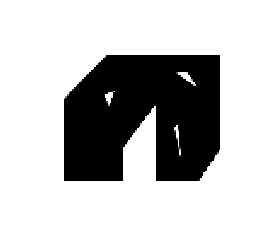

Predicted class for image 1 is : category 1


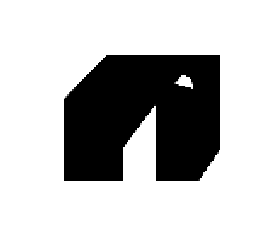

Predicted class for image 2 is : category 1


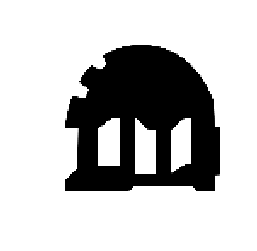

Predicted class for image 3 is : category 3


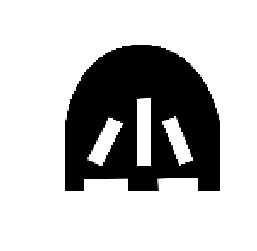

Predicted class for image 4 is : category 3


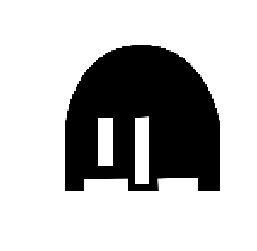

Predicted class for image 5 is : category 3


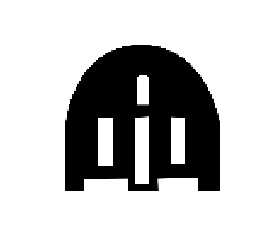

Predicted class for image 6 is : category 3


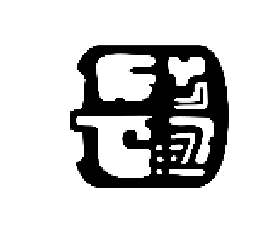

Predicted class for image 7 is : category 2


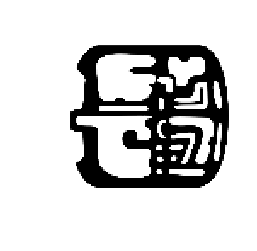

Predicted class for image 8 is : category 2


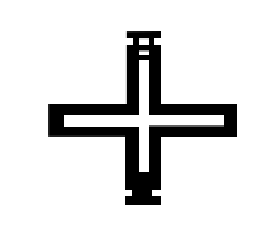

Predicted class for image 9 is : category 4


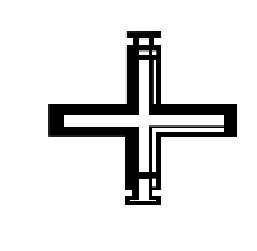

Predicted class for image 10 is : category 4


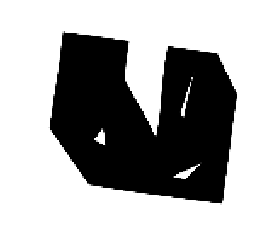

Predicted class for image 11 is : category 1


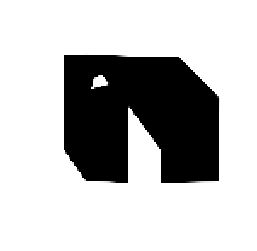

Predicted class for image 12 is : category 1


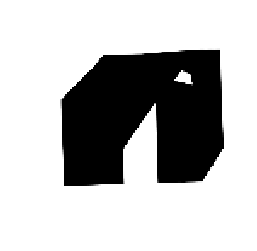

Predicted class for image 13 is : category 1


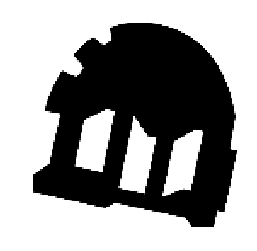

Predicted class for image 14 is : category 3


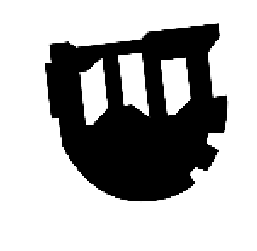

Predicted class for image 15 is : category 3


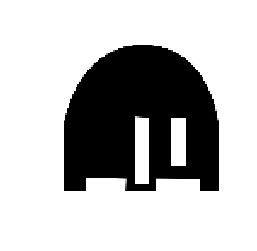

Predicted class for image 16 is : category 3


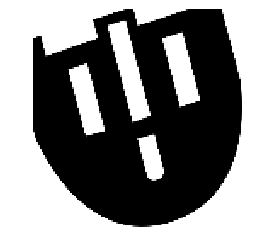

Predicted class for image 17 is : category 3


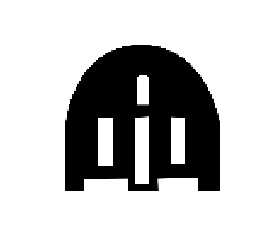

Predicted class for image 18 is : category 3


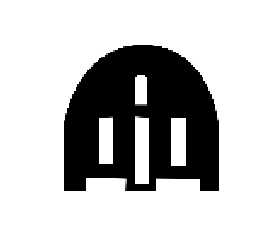

Predicted class for image 19 is : category 3


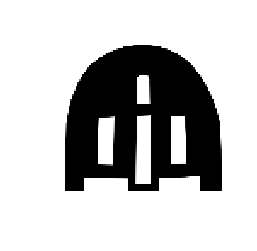

Predicted class for image 20 is : category 3


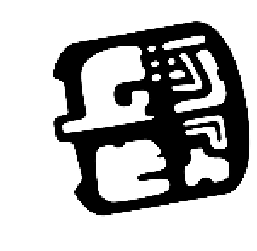

Predicted class for image 21 is : category 2


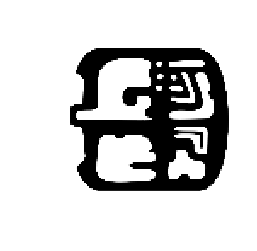

Predicted class for image 22 is : category 2


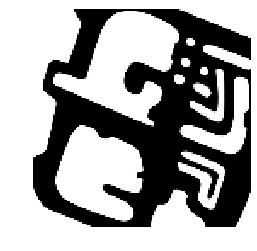

Predicted class for image 23 is : category 2


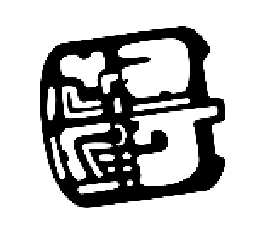

Predicted class for image 24 is : category 2


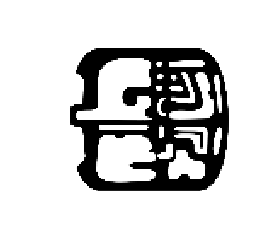

Predicted class for image 25 is : category 2


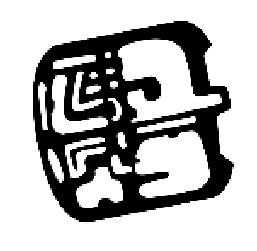

Predicted class for image 26 is : category 2


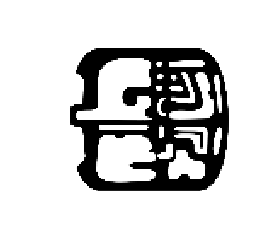

Predicted class for image 27 is : category 2


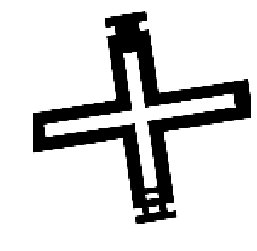

Predicted class for image 28 is : category 4


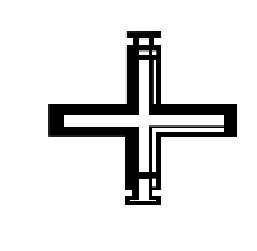

Predicted class for image 29 is : category 4


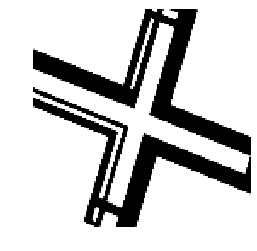

Predicted class for image 30 is : category 4


In [0]:
for i in range(30):
  
  sample_plot(test_images[i])
  
  print("Predicted class for this image {} is : {}".format(i+1,sample_prediction(test_images[i])))